# Milestone 2 Phase 2

- Nama : Naufal Aulia Adam
- Batch : 07
- email : naufal.auliadam@gmail.com

## Dataset Description

This is information about the lack of nutrients. Deficiency by nitrogen, phosphorus, potassium. By means of the lack of nutrients, there are methods as follows: To make the rice plants lack nitrogen Will add nutrients Phosphorus and potassium, but nitrogen is not added.

Kaggle: https://www.kaggle.com/guy007/nutrientdeficiencysymptomsinrice

GDrive: https://drive.google.com/drive/folders/1tI36IuOFkTpCx_tjlj-KGbusw8Gjet3y?usp=sharing

## Import Library

In [1]:
!pip install split-folders

In [2]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import shutil
import random
import splitfolders
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report

## Data Loading

Data diunduh langsung dari Kaggle dengan menggunakan Kaggle Notebook.

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nutrientdeficiencysymptomsinrice/rice_plant_lacks_nutrients/Potassium(K)/untitled-91.JPG
/kaggle/input/nutrientdeficiencysymptomsinrice/rice_plant_lacks_nutrients/Potassium(K)/untitled-185.JPG
/kaggle/input/nutrientdeficiencysymptomsinrice/rice_plant_lacks_nutrients/Potassium(K)/untitled-163.JPG
/kaggle/input/nutrientdeficiencysymptomsinrice/rice_plant_lacks_nutrients/Potassium(K)/untitled-294.JPG
/kaggle/input/nutrientdeficiencysymptomsinrice/rice_plant_lacks_nutrients/Potassium(K)/untitled-255.JPG
/kaggle/input/nutrientdeficiencysymptomsinrice/rice_plant_lacks_nutrients/Potassium(K)/untitled-38.JPG
/kaggle/input/nutrientdeficiencysymptomsinrice/rice_plant_lacks_nutrients/Potassium(K)/untitled-101.JPG
/kaggle/input/nutrientdeficiencysymptomsinrice/rice_plant_lacks_nutrients/Potassium(K)/untitled-250.JPG
/kaggle/input/nutrientdeficiencysymptomsinrice/rice_plant_lacks_nutrients/Potassium(K)/untitled-306.JPG
/kaggle/input/nutrientdeficiencysymptomsinrice/rice_plant_lacks_nu

Data yang sudah diunduh dapat dibagi menjadi data training, data validation, dan data test.

In [4]:
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/kaggle/input/nutrientdeficiencysymptomsinrice/rice_plant_lacks_nutrients/", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False) # default values

Copying files: 1156 files [00:17, 64.58 files/s]


## Exploratory Data Analysis

In [5]:
# Pengarahan lokasi folder
data_dir = pathlib.Path('/kaggle/working/output/train')
train_dir = '/kaggle/working/output/train'
val_dir = '/kaggle/working/output/val'
test_dir = '/kaggle/working/output/test'

In [6]:
# Menampilkan label data
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print('Terdapat kelas: ', class_name)

Terdapat kelas:  ['Nitrogen(N)' 'Phosphorus(P)' 'Potassium(K)']


In [7]:
# Menampilkan jumlah data dalam folder
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"Ada {len(dirnames)} folder dan ada {len(filenames)} gambar di dalam {dirpath}")

Ada 3 folder dan ada 0 gambar di dalam output
Ada 3 folder dan ada 0 gambar di dalam output/test
Ada 0 folder dan ada 22 gambar di dalam output/test/Nitrogen(N)
Ada 0 folder dan ada 18 gambar di dalam output/test/Phosphorus(P)
Ada 0 folder dan ada 20 gambar di dalam output/test/Potassium(K)
Ada 3 folder dan ada 0 gambar di dalam output/val
Ada 0 folder dan ada 88 gambar di dalam output/val/Nitrogen(N)
Ada 0 folder dan ada 66 gambar di dalam output/val/Phosphorus(P)
Ada 0 folder dan ada 76 gambar di dalam output/val/Potassium(K)
Ada 3 folder dan ada 0 gambar di dalam output/train
Ada 0 folder dan ada 330 gambar di dalam output/train/Nitrogen(N)
Ada 0 folder dan ada 249 gambar di dalam output/train/Phosphorus(P)
Ada 0 folder dan ada 287 gambar di dalam output/train/Potassium(K)


Gambar paling banyak berada dalam folder train dengan masing-masing berjumlah lebih besar dari 256, namun kurang dari 512. Jumlah ini dapat dijadikan acuan untuk menentukan node dari masing-masing layer yang akan dipakai.

In [8]:
# Definisi fungsi untuk menampilkan gambar
def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image Shape : {img.shape}")
  return img

Image Shape : (438, 3465, 3)


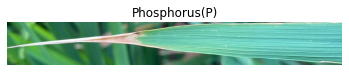

In [9]:
# Menampilkan gambar secara random
img = view_random_image(target_dir='output/train/',
                        target_class=random.choice(class_name))

## Feature Engineering

In [10]:
# Mengatur agar data yang teracak tetap sama
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

## Pipeline

In [11]:
# flow from directory using datagen (Pipeline)
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               seed=46)
test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               seed=46)

Found 866 images belonging to 3 classes.
Found 230 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


## Modelling

Pada pekerjaan ini akan digunakan aplikasi DenseNet169 sebagai model dasar (*base model*).

In [12]:
# Definisi model
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

2022-03-01 09:42:24.636649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-01 09:42:24.731561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-01 09:42:24.732268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-01 09:42:24.733318: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

29097984/29084464 [==============================] - 1s 0us/step


In [13]:
# Persiapan model
global_average_layer = GlobalAveragePooling2D()
layer = Dense(64, kernel_initializer=keras.initializers.LecunNormal(seed=46), activation='selu')
prediction_layer = Dense(3)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
#x = Dropout(0.25)(x)
#x = layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model = Model(inputs, outputs)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1024)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
_________________________________________________________________
activation (Activation)      (None, 3)                 0         
Total params: 7,040,579
Trainable params: 3,075
Non-trainable params: 7,037,504
_______________________________________________

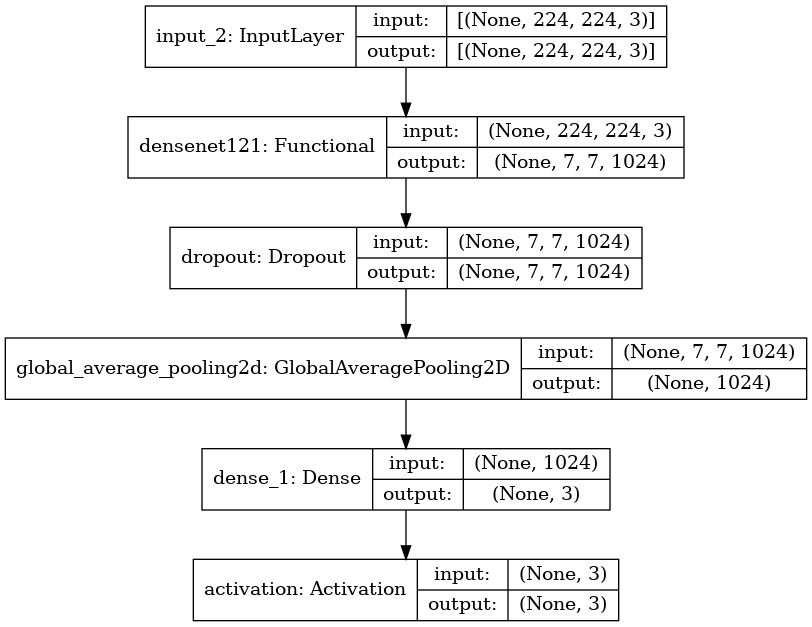

In [14]:
# Summary dari model
model.summary()
# Plot summary dari model
plot_model(model, show_shapes=True)

In [15]:
# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# train model
history = model.fit(train_data,
                    epochs=30,
                    validation_data=valid_data)

2022-03-01 09:42:33.369729: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-03-01 09:42:40.091446: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


55/55 [==============================] - 47s 644ms/step - loss: 1.0404 - accuracy: 0.4965 - val_loss: 0.7375 - val_accuracy: 0.6826
Epoch 2/30
55/55 [==============================] - 33s 606ms/step - loss: 0.5757 - accuracy: 0.8106 - val_loss: 0.5294 - val_accuracy: 0.8261
Epoch 3/30
55/55 [==============================] - 33s 602ms/step - loss: 0.4194 - accuracy: 0.8672 - val_loss: 0.4263 - val_accuracy: 0.8609
Epoch 4/30
55/55 [==============================] - 33s 599ms/step - loss: 0.3495 - accuracy: 0.8926 - val_loss: 0.3704 - val_accuracy: 0.8696
Epoch 5/30
55/55 [==============================] - 33s 599ms/step - loss: 0.2945 - accuracy: 0.9134 - val_loss: 0.3358 - val_accuracy: 0.8913
Epoch 6/30
55/55 [==============================] - 33s 603ms/step - loss: 0.2574 - accuracy: 0.9307 - val_loss: 0.3260 - val_accuracy: 0.8783
Epoch 7/30
55/55 [==============================] - 33s 601ms/step - loss: 0.2322 - accuracy: 0.9319 - val_loss: 0.3052 - val_accuracy: 0.8870
Epoch 8/30

## Model Evaluation

Dalam mengevaluasi model, perlu dilakukan adanya penunjukkan grafik antara data training dengan data validation.

In [16]:
# Definisi fungsi plot
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

Base Model


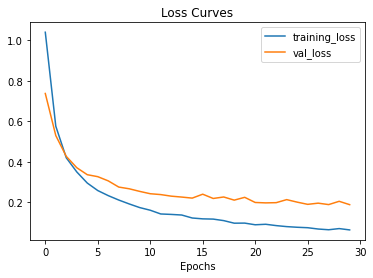

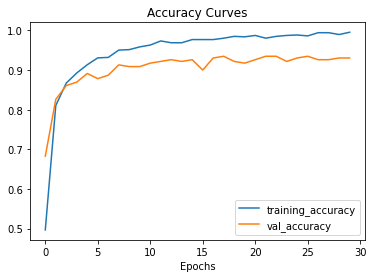

In [17]:
# Menampilkan hasil plot
print("Base Model")
plot_loss_curves(history)

Terlihat bahwa terdapat sedikit celah antara grafik data training dengan grafik data validation. Hal ini mengindikasikan bahwa terjadi sedikit *overfit* pada model, sehingga perlu dilakukan Model Improvement. 

## Model Improvement

Model Improvement dapat dilakukan dengan mengaugementasi gambar pada data training.

In [18]:
# train dengan augmentasi
train_datagen_augmented = ImageDataGenerator(rescale=1/255.0,
                                             rotation_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True)

# flow from directory using datagen (Pipeline)
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               seed=46)

Found 866 images belonging to 3 classes.


In [19]:
# Definisi model
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

In [20]:
# Persiapan model
global_average_layer = GlobalAveragePooling2D()
layer = Dense(64, kernel_initializer=keras.initializers.LecunNormal(seed=46), activation='selu')
prediction_layer = Dense(3)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
#x = Dropout(0.25)(x)
#x = layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model_improv = Model(inputs, outputs)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 1024)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3075      
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 7,040,579
Trainable params: 3,075
Non-trainable params: 7,037,504
_____________________________________________

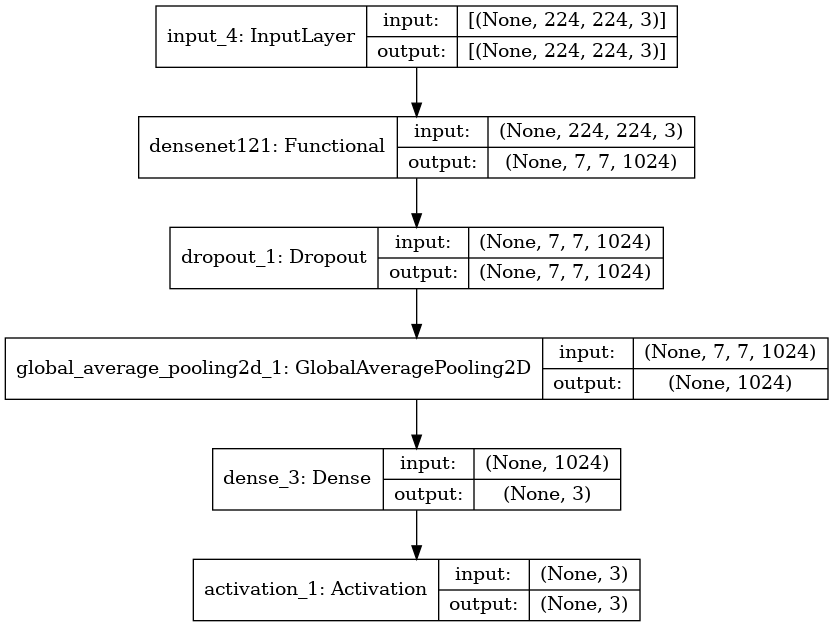

In [21]:
# Summary dari model
model_improv.summary()
# Plot summary dari model
plot_model(model_improv, show_shapes=True)

Selain dengan augmentasi gambar, dapat juga dilakukan pengaturan pada learning rate-nya. Tentunya hal ini akan memakan waktu yang lebih lama dari sebelumnya, sehingga jumlah epoch-nya dapat diperbanyak.

In [22]:
# Definisi optimizer
optimizer = Adam(learning_rate = 0.00001)

# compile model
model_improv.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# train model
history_improv = model_improv.fit(train_data_augmented,
                    epochs=175,
                    validation_data=valid_data)

Epoch 1/175
55/55 [==============================] - 47s 770ms/step - loss: 1.2815 - accuracy: 0.3603 - val_loss: 1.2063 - val_accuracy: 0.4348
Epoch 2/175
55/55 [==============================] - 41s 745ms/step - loss: 1.2509 - accuracy: 0.3580 - val_loss: 1.1804 - val_accuracy: 0.4348
Epoch 3/175
55/55 [==============================] - 40s 736ms/step - loss: 1.2280 - accuracy: 0.3695 - val_loss: 1.1612 - val_accuracy: 0.4261
Epoch 4/175
55/55 [==============================] - 41s 731ms/step - loss: 1.2121 - accuracy: 0.3580 - val_loss: 1.1480 - val_accuracy: 0.4217
Epoch 5/175
55/55 [==============================] - 40s 732ms/step - loss: 1.1948 - accuracy: 0.3649 - val_loss: 1.1369 - val_accuracy: 0.4217
Epoch 6/175
55/55 [==============================] - 40s 737ms/step - loss: 1.1834 - accuracy: 0.3764 - val_loss: 1.1278 - val_accuracy: 0.4304
Epoch 7/175
55/55 [==============================] - 40s 737ms/step - loss: 1.1810 - accuracy: 0.3811 - val_loss: 1.1184 - val_accuracy:

New Model


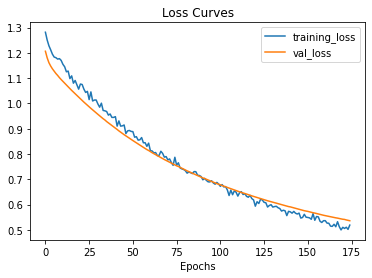

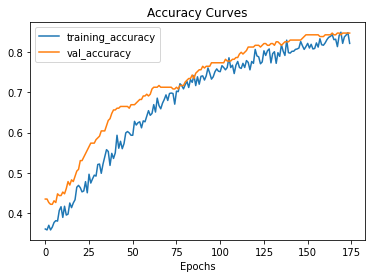

In [23]:
# Menampilkan hasil plot
print("New Model")
plot_loss_curves(history_improv)

Terlihat bahwa model yang dihasilkan jauh lebih baik dari sebelumnya.

## Model Inference

In [24]:
tes_data = test_data.next()

In [25]:
res = model.predict(tes_data[0])
y_test = np.array(tes_data[1]).argmax(axis=1)
res = res.argmax(axis=1)
print(classification_report(y_test, res))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.75      0.75      0.75         4
           2       1.00      0.80      0.89         5

    accuracy                           0.88        16
   macro avg       0.88      0.85      0.86        16
weighted avg       0.88      0.88      0.87        16



## Conclusion

Dataset yang digunakan adalah dataset untuk memprediksi nutrisi yang kurang dari sebuah tanaman padi. Cukup sulit dalam membangun model prediksinya, karena secara kasat mata, tidak terlalu ada perbedaan yang signifikan antara satu sampel dengan yang lain. Hal ini menjadi pertimbangan yang sulit apakah ingin membangun model berdasarkan model yang *deep* atau tidak. Model DenseNet169 merupakan model yang cukup *deep*, namun memiliki ukuran dan parameter yang tidak terlalu banyak, oleh karena itu model tersebut dipakai dalam pekerjaan ini.

Dataset ini cukup besar, namun label-label yang ada masih tergolong kurang, terutama mengenai dataset terkait padi yang cukup akan nutrisi. Harapannya, dataset ini dapat berkembang sehingga dalam proyek mendatang dapat dibangun model yang lebih membantu orang-orang dalam mengklasifikasi tanaman padi.